In [3]:
# use env: pycircos

import os
import pycircos
import matplotlib as mpl
import matplotlib.pyplot as plt
from Bio import SeqIO, SeqFeature
from BCBio import GFF
import pandas as pd
import numpy as np
import copy

nbname = '20230201-phage_genome_circ'
path_target = os.path.join(os.getcwd(), "data/{}".format(nbname))

# create target directory if not exists
if not os.path.exists(path_target):
    os.mkdir(path_target)

In [8]:
def get_gbk(fgbk, sample_id=False):
    records = list(SeqIO.parse(fgbk, "genbank"))
    # only return the first record
    record = records[0]
    if sample_id:
        record.id = sample_id
        record.name = sample_id
    record.features.append(SeqFeature.SeqFeature(SeqFeature.FeatureLocation(0, len(record)), type="source", strand=1))
    return record


def get_cds(record):
    # feature locations store in a list [feature_id, start, end, strand]
    feature_locations = []
    for feature in record.features:
        if feature.type == "CDS" or feature.type == "HIT":
            # get phrog annotation if exists
            if "annotation_PHROGS" in feature.qualifiers:
                phrogs = feature.qualifiers["annotation_PHROGS"]
                phrog_integrase = [phrog for phrog in phrogs if "integrase" in phrog]
                if len(phrog_integrase)>0:
                    phrog_anno = phrog_integrase[0]
                else:
                    phrog_anno = phrogs[0]
                phrog_anno = phrog_anno.split("~")[0].split("_")[1]
            else:
                phrog_anno = "No_PHROG"
            feature_locations.append([feature.qualifiers["locus_tag"][0], phrog_anno, feature.location.start.real, feature.location.end.real])

    # convert to dataframe
    df_cds = pd.DataFrame(feature_locations, columns=["feature_id", "phrog", "start", "end"])
    # width of each feature
    df_cds["width"] = df_cds["end"] - df_cds["start"] + 1
    return df_cds


def read_phrog_annot(fin="/Users/allen/data2/db/phrogs/phrog_annot_v4.tsv"):
    df_phrog = pd.read_csv(fin, sep="\t")
    # convert column "phrog" to str
    df_phrog["phrog"] = df_phrog["phrog"].astype(str)
    return df_phrog


def add_phrog_to_cds(df_cds, df_phrog):
    df_cds = df_cds.merge(df_phrog, on="phrog", how="left")
    # fill NaN in column "color" with #222223
    df_cds["color"] = df_cds["color"].fillna("#c9c9c9")
    # fill NaN in column "category" with "Unknown"
    df_cds["category"] = df_cds["category"].fillna("unknown function")
    return df_cds


def plot_circos(record, df_cds_anno, label):
    tick_interval = 10000
    tick_label_size = 8
    window_size = 1000
    sample_id = record.id
    tick_max = len(record.seq)

    garc = pycircos.Garc(arc_id=sample_id, record=record, interspace=0, linewidth=0, facecolor="black", raxis_range=(0,0), label=label, label_visible=True)
    gcircle = pycircos.Gcircle(figsize=(8,8))
    gcircle.add_garc(garc)
    gcircle.set_garcs(0, 360)

    # add tickplot
    tlabels = [f"{tl / 1000:.0f} K" for tl in range(0, tick_max, tick_interval)]
    gcircle.tickplot(sample_id, raxis_range=(600,607), tickinterval=tick_interval, tickcolor="#7B7D7D", ticklabels=tlabels, ticklabelsize=tick_label_size, ticklabelorientation="horizontal")
    gcircle.tickplot(sample_id, raxis_range=(600,602), tickinterval=int(tick_interval/10), tickcolor="#7B7D7D")

    # Plot source
    feat_source = []
    for feat in garc.record.features:
        if feat.type == "source":
            feat_source.append(feat)
            a = feat
    # gcircle.featureplot(sample_id, source=feat_source, raxis_range=(510,511), facecolor="#36454F")

    #Plot CDS
    feat_CDS_plus  = []
    feat_CDS_minus = []
    for feat in garc.record.features:
        if "CDS" in feat.type:
            if feat.strand == 1:
                feat_CDS_plus.append(feat)
            else:
                feat_CDS_minus.append(feat)
    gcircle.featureplot(sample_id, source=feat_CDS_minus, raxis_range=(480,510), facecolor="#C1A7E2")
    gcircle.featureplot(sample_id, source=feat_CDS_plus,  raxis_range=(450,480), facecolor="#69B3E7")


    # PHROGs
    gcircle.barplot(sample_id, data=[1]*len(df_cds_anno["start"]), positions=df_cds_anno["start"], width=df_cds_anno["width"], raxis_range=(513, 598), facecolor=df_cds_anno["color"])

    return gcircle


def main(fgbk, dirout, bcoat_locus_tag, label="VC-1"):
    record = get_gbk(fgbk)
    df_cds = get_cds(record)
    df_phrog = read_phrog_annot()
    tick_max = len(record) + 1000
    df_cds_anno = add_phrog_to_cds(df_cds, df_phrog)

    # if feature_id == "BAF3_00080", set color to #FF0000
    df_cds_anno.loc[df_cds_anno["feature_id"] == bcoat_locus_tag, "color"] = "#FF0000"
    # if feature_id == "BAF3_00080", set category to "BCoAT"
    df_cds_anno.loc[df_cds_anno["feature_id"] == bcoat_locus_tag, "category"] = "BCoAT"

    fig1 = plot_circos(record, df_cds_anno, label)
    # fig1.save("circ_BAM3.pdf", format="pdf")
    fout = os.path.join(dirout, label)
    fig1.save(fout, format="pdf")

/var/folders/z1/p1tn13ts49j70fwn852mnwhm0000gn/T/ipykernel_16327/276103854.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_phrog = df_phrog.append(pd.Series(["#FF0000", "BCoAT"], index=df_phrog.columns), ignore_index=True)


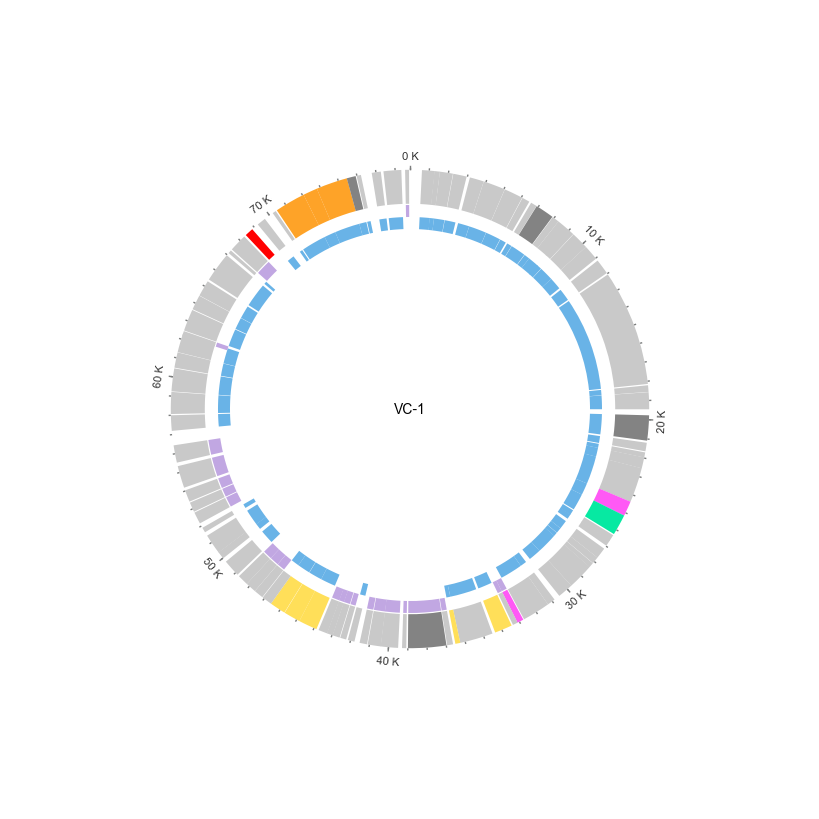

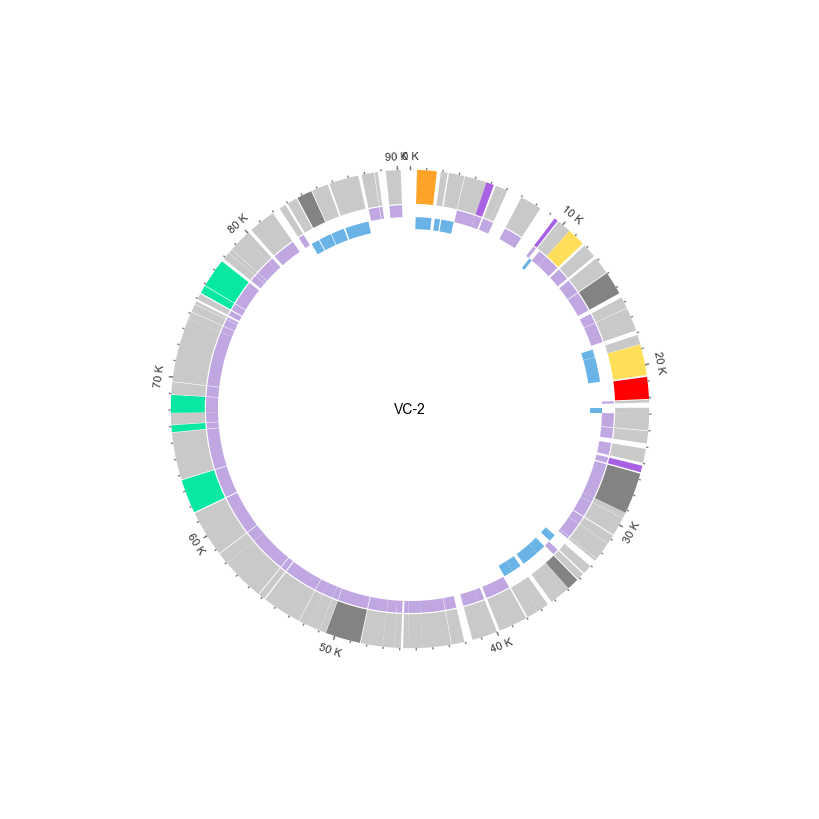

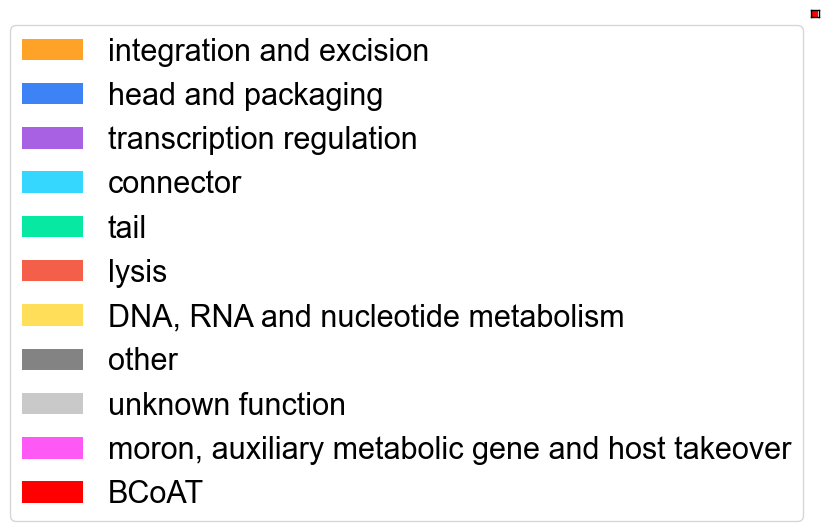

In [9]:
main('data/00-rawdata/gggenomes/BAF3/BAF3.gbk', path_target, "BAF3_00080", label="VC-1")
main('data/00-rawdata/gggenomes/BAM6/BAM6.gbk', path_target, "BAM6_00020", label="VC-2")

# Legend
df_phrog = read_phrog_annot()
df_phrog = df_phrog[["color", "category"]]
df_phrog = df_phrog.drop_duplicates()
# add ["#FF0000", "BCoAT"] to df_phrog
df_phrog = df_phrog.append(pd.Series(["#FF0000", "BCoAT"], index=df_phrog.columns), ignore_index=True)

# create color legend for PHROGs vertical
fig, ax = plt.subplots(figsize=(0.1, 0.1))
for i, row in df_phrog.iterrows():
    ax.barh(0, 1, color=row["color"], label=row["category"])
ax.set_yticks([])
ax.set_xticks([])
ax.legend(loc="best", frameon=True, fontsize=22)
fig.savefig("{}/{}".format(path_target, "phrog_legend.pdf"), bbox_inches="tight")